## Style Transfer with CNNs

*Most resources imported from the Tensorflow tutorial, exceptions listed in the markdown cell at the bottom of the notebook*

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'


C:\Users\Audrey\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [141]:
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


In [142]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


### Visualizing Input

In [143]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)


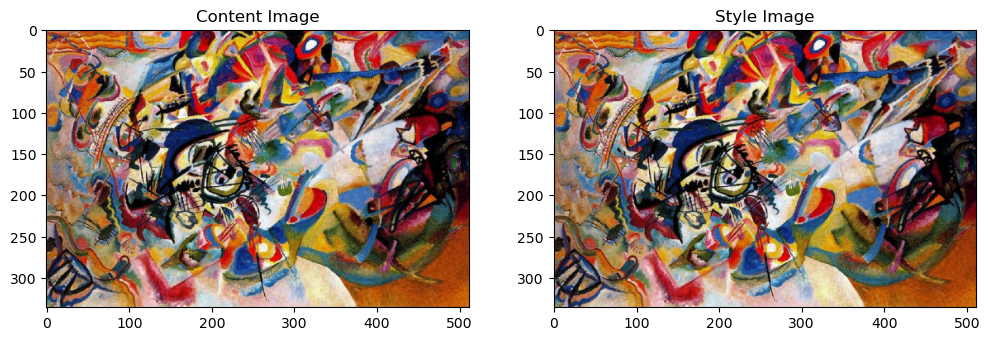

In [144]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')


### Define Content and Style Representations

In [145]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape


TensorShape([1, 1000])

In [146]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]


[('sarong', 0.43203944),
 ('kimono', 0.29898256),
 ('apron', 0.037469447),
 ('shower_curtain', 0.03579498),
 ('poncho', 0.02674889)]

In [147]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_layer_21
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [148]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


### Building the Model

In [149]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model


In [150]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()


block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.13
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



### Calculate the Style

In [151]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


### Extract Style and Content

In [152]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [153]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.09435934
    max:  15339.603
    mean:  927.4778

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  417848.9
    mean:  35192.938

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  1765942.1
    mean:  49054.164

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  23451370.0
    mean:  534245.7

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  208783.53
    mean:  3357.227

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1332.977
    mean:  22.29913


### Run Gradient Descent

In [154]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [155]:
image = tf.Variable(content_image)

In [156]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [157]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [158]:
style_weight=1e-2
content_weight=1e4

In [159]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [160]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


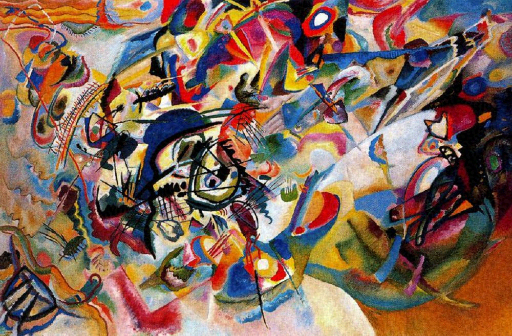

In [161]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)


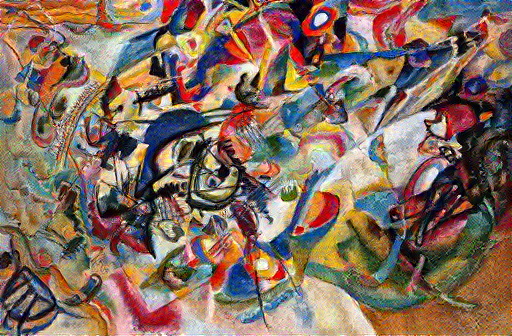

Train step: 1000
Total time: 2035.0


In [162]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
# Longer optimization

## Total Variation Loss

In [111]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

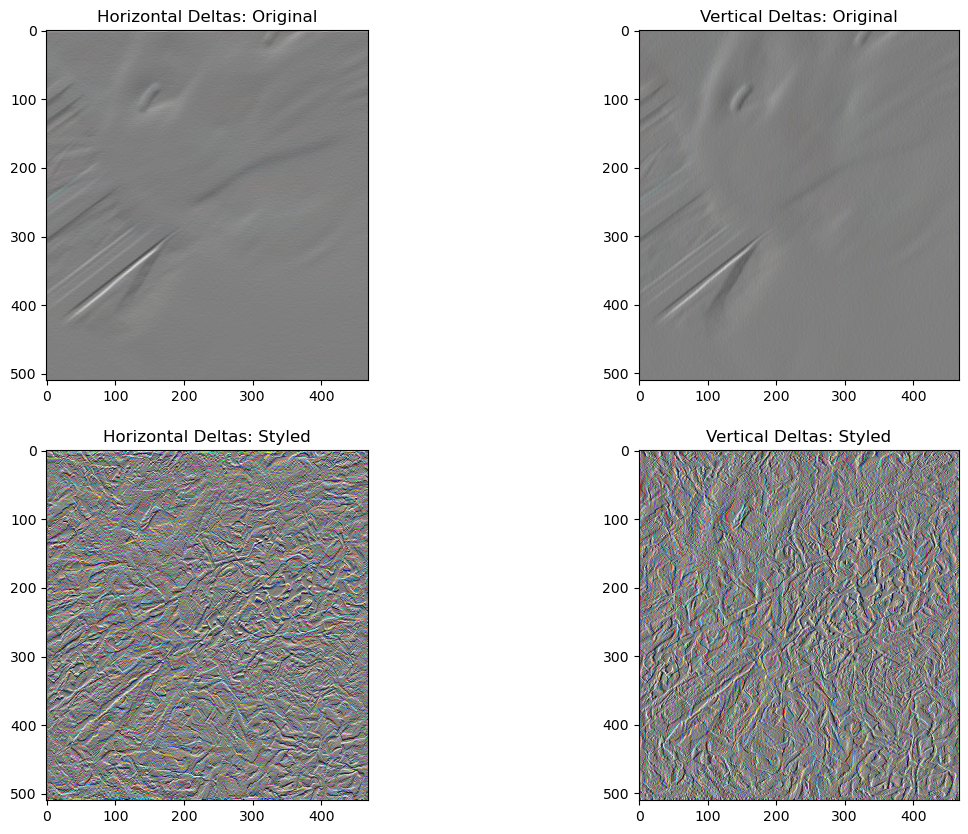

In [112]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

# Basically an edge detector

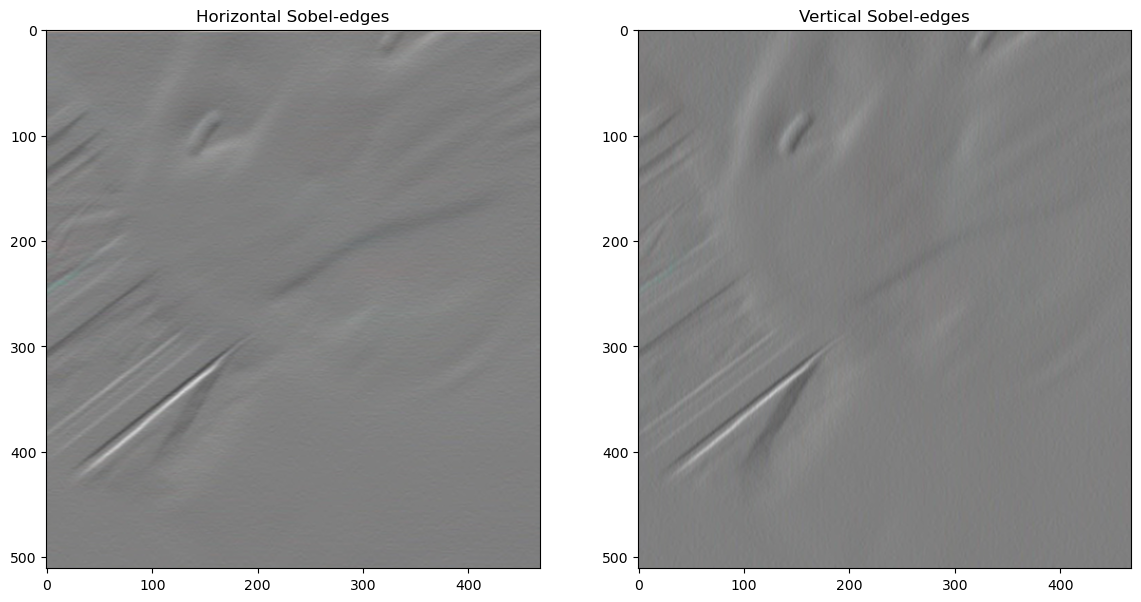

In [113]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")


In [114]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [115]:
total_variation_loss(image).numpy()

160337.7

In [116]:
tf.image.total_variation(image).numpy()

array([160337.7], dtype=float32)

## Rerunning Optimization

In [32]:
total_variation_weight=30

In [33]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

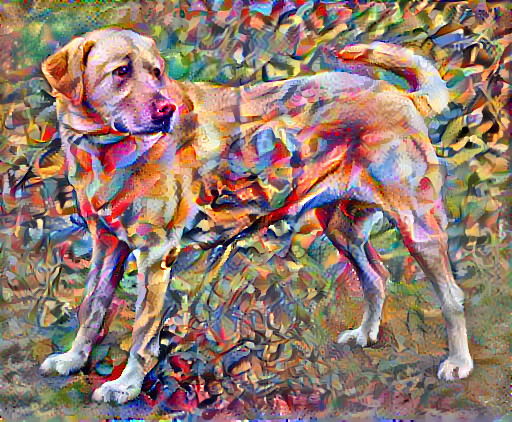

Train step: 1000
Total time: 2921.8


In [35]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### Saving Result

In [88]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)


## EXPERIMENTS, INVESTIGATIONS, AND MORE

### EXPERIMENTS
Control time: 2874.8/2921.8

##### Swapping style and reference
2337.8
We now have a green and tan abstract picture! I didn't expect anything crazy from this, but the original beautifully colored picture becomes rather homogenous, mainly green with a little bit of tan on the edges. I found that the tan was really only where there was tan in the original picture - the rest became green.

###### Same image for both
2035.0
I did both the abstract art. It just looks probably like the same picture - there's probably some greater image frequency in the ML one? It also looks like a little lower resolution. Shortest training time for all of them. But the greater image frequency makes sense - there's much more pixel color/brightness variation even within a single region.

##### No pattern, just color
The VGG still tried to find a pattern even in a plain blue image, so the dog turned out desaturated at the bottom and had a sorta leopard-print in blue and pink at the top? It looked like if you had a broken TV/computer screen with pixelation.
##### Using a non-realistic image (ex. famous painting)
2890.9
After using The Girl with the Pearl Earring and the same style from the dog, I noticed that it was harder for the VGG to detect the edges (especially on the lips, as the pink part is notably smudged) and it has trouble nailing down a cohesive color scheme. 
##### Using a blurry image - does the blur get reflected? It should be harder to detect edges. 
[('hamster', 0.22051598),
 ('black-footed_ferret', 0.07193428),
 ('cassette', 0.044034775),
 ('accordion', 0.030161446),
 ('feather_boa', 0.018852795)]
 <br>
 I thought it was funny that it struggled to identify the cat. It also said the Girl with the Pearl Earring was a vestment or cloak. I also checked the edge detector on the source photo as well. 
 
Even as the model was still running, I figured that it was operating under the misclassification of the cat as a hamster. Suddenly, the pointed nose and ears start to round out and the blur that was around the face solidifies into a much wider shape. The orange of the ear instead turns into the ear to form a more hamster-like shape, with the remaining pointiness of the ear blurring into the background. There was a LOT more indistinct color here than in other photos.

The deltas and the sobel edges were also nonexistent on the cat, only slightly outlining the cat's features. It makes sense with the interpretation.

### INVESTIGATIONS
##### Look up what vgg does - are there other parameters we didn't look at?
https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/ and https://keras.io/api/applications/vgg/#vgg19-function
VGG stands for Visual Geometry Group. The 16 and 19 refer to the "depth" of the algorithm, with 16 and 19 layers respectively. As opposed to other CNNs, VGGs have very small convolutional filters, which can get as small as 3x3 or 1x1 (which act as a linear transformation of the input). These are followed by a ReLU unit (and all the hidden layers also use ReLU). However, as we can see in the lab, VGGs are huge networks so it takes a long time to train. I've been writing this entire thing while my model has hit halfway through training step 300. 
<br>
One of the parameters I found interesting is "weights" - you can load a weights file, for example, from imagenet (aka pre-training the model a little bit). I also learned about "pooling", which reduces dimensionality and the number of parameters of the feature maps. VGG16 and VGG19 share the same parameters.
<br>
##### They suggested TF-Hub as an easier way to do it, what is this method? Why does it work so efficiently compared to VGG?
Checked out this tutorial linked in the neural style transfer tutorial
https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization
In the tutorial, they crop the image to a square before even building the model - this helps standardize the input. They also note the style prediction model was trained with 256x256 so it's best to keep it like that, at least for the content image. The style image doesn't matter because the final image will be the same dimensions as the content image. The same module can be used to process more than 1 image as long as you change the batch size to > 1. Also, TF-Hub contains one of many pretrained models, so they may not have to endure all this training time that I'm currently experiencing with VGG (we are on training step 600 rn).  There's much less code in this tutorial. Some of the steps listed in this notebook that aren't in the TF-Hub tutorial are calculating the style, finding edges, or even building a model. By importing a pre-trained model, we don't even have to build our own model.

##### What the hell is GradientTape?
https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape
In its simplest form, GradientTape will give you "direct access" to a custom layer you built. GradientTape is an optimizer that also tracks the automatic differentiation that occurs in a TensorFlow model. The reason why we ran it here is to update the image since it keeps track of operations. 

##### What is image frequency?
https://arxiv.org/abs/2006.15476
https://www.labmanager.com/recognizing-fake-images-using-frequency-analysis-23313
Like how gradient represents slope, image frequency also deals with a change. Image frequency refers to the change in aspects such as color/brightness as one progresses across the image. 

It can be used to tell whether an image is AI generated or not - normal photos usually do not contain such high-frequency spots, or drastic changes in brightness or color. It shows that AI is good at what it's made to do, classify sections.  

##### How does einsum "mathematically compute" the style?
https://rockt.github.io/2018/04/30/einsum
Also known as *Einstein Summation*, einsum helps with calculating dot products, outer products, transposes and matrix-vector or matrix-matrix multiplications. It is usually used for multiplications, and can be represented through multiplication of summations. With einsum, those sum notations are dropped. In the above article, Tim suggests that its use in Tensorflow is for applying a transformation to vectors in a higher-order tensor. In the examples, he demonstrates multiplying an order-3 tensor by a projection matrix.
<br>
Specifically in terms of style, the style can be computed using a Gram matrix, since it can be described by the means and correlations across the different feature maps. And since a Gram matrix includes multiple sums, it's good to use einsum. It's all about concise implementation.